<a href="https://colab.research.google.com/github/juanPellegrini11/Yi_River_Level_Predictions/blob/main/ANN_Durazno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-objective optimization and its application on flood models calibration in Rio Yi basin Uruguay**

Floods significantly impact the well-being and development of communities. Hence, understanding their causes and establishing methodologies for risk prevention is a critical challenge for effective warning systems. Flood modeling involves simulating the behavior and dynamics of flood events to understand their extent, flow patterns, and potential impacts. The proper selection of objective function combinations for evaluating modeling techniques is an essential step in developing and calibrating flood models. It is also crucial when communicating modeling results to the scientific community and stakeholders. The modeling community has a well-tested toolbox of metrics to evaluate hydrological model performance. These metrics have been adopted by flood modelers to evaluate flood models. However, there is a lack of robust spatial metrics to confirm the consistency of the outcomes. Various objective functions exist, but analyzing and evaluating combinations of objective functions to select optimal parameters and inputs have not been thoroughly studied, particularly for flood hazard models. This study proposes a robust methodology for the evaluation of flood model results in a holistic sense. It contributes to the advancement of spatial-pattern-oriented model calibration by introducing a multi-component performance metric tested through a genetic algorithm.

In [1]:
!pip install neptune
!pip install pymongo
!pip install keras==2.12.0
#Librarys
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.models import Sequential
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from numpy.random import seed
from time import time
import os
import io
import neptune
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from pymongo import MongoClient
from pandas import json_normalize

seed_number = 28
seed(seed_number)
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

In [ ]:
def nse(y_true, y_pred):
	return 1 - (K.sum((y_pred - y_true)**2)/
                         K.sum((y_true - K.mean(y_true))**2))

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def nse_randomForest(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mean_observed = np.mean(y_true)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - mean_observed) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [ ]:
def get_max_nse(history):
    validation = history.history["val_nse"]
    ymax = max(validation)
    return "Max NSE ≈ " + "%.6f" % ymax

def get_metrics(history):
    validation_rmse = history.history["val_rmse"]
    validation_nse = history.history["val_nse"]
    return min(validation_rmse), max(validation_nse)

def plot_history(history, title):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

  fig.suptitle(title)

  ax1.plot(history.history['nse'], label='train')
  ax1.plot(history.history['val_nse'], label='test')
  ax1.set_ylabel('nse')
  ax1.set_xlabel('epoch')

  ax2.plot(history.history['loss'], label='train')
  ax2.plot(history.history['val_loss'], label='test')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

  ax1.text(
        0.97,
        0.97,
        get_max_nse(history),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax1.transAxes,
        fontsize=18,
    )
  plt.legend()
  plt.show()

In [ ]:
def conexion():
    usuario = ''
    contrasenia = ''
    servidor = 'hidrologiaserverless.9ymsvyt.mongodb.net'
    baseDatos = 'datos_hidrologia'
    uri = f'mongodb+srv://{usuario}:{contrasenia}@{servidor}/{baseDatos}?retryWrites=true&w=majority&appName=HidrologiaServerless'
    cliente = MongoClient(uri)
    db = cliente[baseDatos]
    return db

def consultar(db, coleccion, filtro = '', proyeccion = ''):
    datos = db[coleccion].find(filtro, proyeccion)
    return datos

In [ ]:
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
#simplefilter("ignore")
plt.rcParams["font.family"] = 'sans-serif'

import neptune

run = neptune.init_run(
    project="Hidrologia/Hidrologia",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ZWY2M2ExYS1kNGVlLTQ5ZmEtODY2NS03YmI1OGZjZGMxOGQifQ==",
)

NameError: name 'sns' is not defined

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# df = pd.read_csv('Datos_level_rain_satelite.csv')
db = conexion()

datos_tiempo = consultar(db, 'datos_tiempo')

# Convertir los datos obtenidos a una lista de diccionarios
lista_datos = list(datos_tiempo)

# Crear un DataFrame de pandas a partir de la lista de diccionarios
df = json_normalize(lista_datos)

In [ ]:
df['fecha'].unique()

array([datetime.datetime(2015, 4, 1, 0, 0),
       datetime.datetime(2015, 4, 2, 0, 0),
       datetime.datetime(2015, 4, 3, 0, 0), ...,
       datetime.datetime(2015, 3, 29, 0, 0),
       datetime.datetime(2015, 3, 30, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0)], dtype=object)

In [2]:
data_satelites_DZ = pd.read_csv('precipitaciones_ute_IMERG_MERRA_DZ.csv')[:2017]
data_satelites_Polanco = pd.read_csv('precipitaciones_ute_IMERG_MERRA_Polanco.csv')[:2017]
data_satelites_Sarandi = pd.read_csv('precipitaciones_ute_IMERG_MERRA_Sarandi.csv')[:2017]
df = pd.read_csv('data_con_niveles.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'precipitaciones_ute_IMERG_MERRA_DZ.csv'

In [ ]:
# Se crean columnas en df principal agregando datos satelitales
df['Precipitaciones_IMERG_Durazno'] = data_satelites_DZ['Precipitaciones_IMERG_Durazno']
df['Precipitaciones_MERRA_Durazno'] = data_satelites_DZ['Precipitaciones_MERRA_Durazno']
df['Precipitaciones_IMERG_Polanco_del_Yi'] = data_satelites_Polanco['Precipitaciones_IMERG_Polanco_del_Yi']
df['Precipitaciones_MERRA_Polanco_del_Yi'] = data_satelites_Polanco['Precipitaciones_MERRA_Polanco_del_Yi']
df = df.merge(data_satelites_Sarandi[['Fecha', 'Precipitaciones_IMERG_Sarandi_del_Yi', 'Precipitaciones_MERRA_Sarandi_del_Yi']],
               left_on='dt', right_on='Fecha', how='left')
df = df.drop(['Fecha'], axis=1)
df.dropna(inplace=True)

In [ ]:
#configure the data index

df['dt']=pd.to_datetime(df['dt'])

In [ ]:
data=df.set_index('dt')

In [ ]:
data.index = pd.to_datetime(data.index)
#data.head(40)

In [ ]:
# Descargar data en csv
data.to_csv('data.csv')
files.download('data.csv')

In [ ]:
data = data.drop(['Manuel Diaz', 'Cunapiru', 'Coelho', 'Toscas', 'Manzagano', 'Laguna',
       'Aguiar', 'Laguna II', 'Pereira', 'Salsipuedes', 'San gregorio',
       'Paso de lo toros', 'Bonete', 'Mercedes', 'Lugo',
        'Soriano', 'Bonete_level',
       'Manuel_Díaz_level', 'Cuñapirú_level', 'Mazangano_level',
       'Coelho_level', 'Paso_de_las_Toscas_level', 'Aguiar_level',
       'Laguna_I_level', 'Laguna_II_level', 'Pereira_level',
       'San_Gregorio_level', 'Paso_de_los_Toros_level', 'Salsipuedes_level', 'Lugo_level',
       'Mercedes_level', 'Villa_Soriano_level', 'Bonete_precipitation',
       'Manuel_Diaz_precipitation', 'Cuñapirú_precipitation',
       'Mazagano_precipitation', 'Coelho_precipitation',
       'Paso_de_las_Toscas_precipitation', 'Aguiar_precipitation',
       'Laguna_I_precipitation', 'Laguna_II_precipitation',
       'Pereira_precipitation', 'San_Gregorio_precipitation',
       'Paso_de_los_toros_precipitation', 'Salsipuedes_precipitation', 'Paso_de_Lugo_precipitation',
       'Mercedes_precipitation', 'Villa_Soriano_precipitation' ], axis=1)

In [ ]:
tipos_prueba = {}

pluv = ['Durazno_precipitation', 'Polanco_precipitation', 'Sarandi_del_Yi_precipitation']
merra = ['Precipitaciones_MERRA_Durazno', 'Precipitaciones_IMERG_Polanco_del_Yi', 'Precipitaciones_MERRA_Sarandi_del_Yi']
imerg = ['Precipitaciones_IMERG_Durazno', 'Precipitaciones_IMERG_Polanco_del_Yi', 'Precipitaciones_IMERG_Sarandi_del_Yi']
eras = ['Durazno', 'Sarandi del yi', 'Polanco del yi']

# Pruebas de cada fuente
# tipos_prueba['Pluv'] = pluv
# tipos_prueba['MERRA'] = merra
# tipos_prueba['IMERG'] = imerg
# tipos_prueba['ERAS'] = eras

# Pruebas de dos fuentes
# tipos_prueba['Pluv_MERRA'] = pluv + merra
# tipos_prueba['Pluv_IMERG'] = pluv + imerg
# tipos_prueba['Pluv_ERAS'] = pluv + eras
# tipos_prueba['ERAS_IMERG'] = eras + imerg
# tipos_prueba['ERAS_MERRA'] = eras + merra
# tipos_prueba['IMER_MERRA'] = imerg + merra

# Pruebas de tres fuentes
# tipos_prueba['Pluv_IMERG_MERRA'] = pluv + imerg + merra
# tipos_prueba['Pluv_ERAS_MERRA'] = pluv + eras + merra
# tipos_prueba['Pluv_ERAS_IMERG'] = pluv + eras + imerg
tipos_prueba['ERAS_IMERG_MERRA'] = eras + imerg + merra

# Pruebas de cuatro fuentes
# tipos_prueba['Pluv_ERAS_IMERG_MERRA'] = pluv + eras + imerg + merra

In [ ]:
def compilar_modelo():

  run = neptune.init_run(
    project="Hidrologia/Hidrologia",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ZWY2M2ExYS1kNGVlLTQ5ZmEtODY2NS03YmI1OGZjZGMxOGQifQ==",
  )

  if model.__class__.__name__ == 'RandomForestRegressor':
    # Train the model
    model.fit(x_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)

    # Evaluate the model
    rmse_result = sqrt(mean_squared_error(y_test, y_pred))
    nse_result = nse_randomForest(y_test, y_pred)

    modelo = 'RandomForestRegressor'
    params = {'n_estimators': 500, 'max_depth': 30}
    run['rmse'] = rmse_result
    run['nse'] = nse_result

  else:
    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[rmse, nse])
    model.summary()

    # Fitting the model to the Training set
    history = model.fit(x_train, y_train, epochs = 350, batch_size = 100, validation_data=(x_val, y_val))

    print(get_metrics(history))
    plot_history(history, f'Train - Input: {tipo_prueba} + Level from 3 stations - Output: Level in Durazno station')

    if isinstance(model.layers[0], keras.layers.LSTM):
      modelo = 'LSTM'
    if all([isinstance(layer, keras.layers.Dense) for layer in model.layers]):
      modelo = 'MLP'

    params = {'optimizer': 'Adam', 'batch_size': 100, 'epochs': 350, 'loss': 'mean_squared_error'}
    run['rmse'] = get_metrics(history)[0]
    run['nse'] = get_metrics(history)[1]

    for epoch in range(350):
      run["train/loss"].append(history.history['loss'][epoch])
      run["train/nse"].append(history.history['nse'][epoch])
      run["val/loss"].append(history.history['val_loss'][epoch])
      run["val/nse"].append(history.history['val_nse'][epoch])

  run['parameters'] = params
  run['tipo_prueba'] = tipo_prueba
  run['model'] = modelo

  run.stop()

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
# Considera como entrada los datos de precipitación y nivel de todas las estaciones para el tiempo t

tipos_prueba = {'Niveles': []}
for tipo_prueba, columnas_prueba in tipos_prueba.items():

  x = scaler.fit_transform(data[columnas_prueba + ['Sarandi_del_Yi_level', 'Polanco_level', 'Durazno_level']].values)

  #Considera como salida los datos de nivel para la estacion de Durazno para el tiempo t + 1
  #y = x[:,1::2]
  y = x[:,x.shape[1] - 1]

  date_split = pd.to_datetime(datetime.datetime(year=2019, month=3, day=15, hour=7, minute=0))
  #date_split = pd.to_datetime(datetime.datetime(year=2017, month=1, day=1, hour=7, minute=0))
  #date_split = pd.to_datetime(datetime.datetime(year=2016, month=4, day=26, hour=7, minute=0))
  train_index = data.loc[data.index<date_split]

  i = 1
  ## Remove o ultimo tempo do df de x e o primeiro do df de y
  in_data = x[:-i]
  out_data = y[i:]

  print(in_data.shape)
  print(out_data.shape)

  #Split train and test data

  x_train_without_test = in_data[0:train_index.shape[0],]
  y_train_without_test = out_data[0:train_index.shape[0],]
  x_test = in_data[train_index.shape[0]:,]
  y_test = out_data[train_index.shape[0]:,]
  x_train, x_val, y_train, y_val = train_test_split(x_train_without_test, y_train_without_test, test_size=0.2, random_state=seed_number)

  input_dim = x_train.shape[1]

  # Build the model LSTM
  model = keras.Sequential()

  model.add(LSTM(units = 9, return_sequences = True, input_shape=(input_dim, 1), activation='relu'))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 9, activation='relu'))
  model.add(Dropout(0.2))

  # Output layer
  model.add(Dense(units = 1, activation='relu'))

  compilar_modelo()

  # Implemnt MLP neural network

  input_dim = x_train.shape[1]
  model = Sequential()

  model.add(Dense(9,input_shape=(input_dim,),activation='relu'))
  model.add(Dense(9, activation='relu'))
  model.add(Dense(1, activation='linear'))

  compilar_modelo()

  # Random Forest
  model = RandomForestRegressor(n_estimators=500, max_depth=30, random_state=seed_number)

  compilar_modelo()

(1926, 3)
(1926,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Hidrologia/Hidrologia/e/HID5826-107


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 9)                │             396 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 9)                   │             684 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,090 (4.26 KB)

 Trainable params: 1,090 (4.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/350


AttributeError: module 'keras.api.backend' has no attribute 'sqrt'

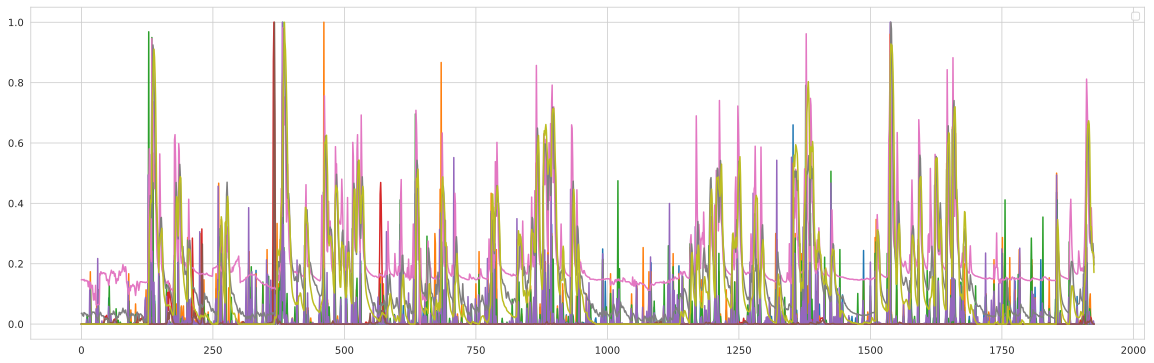

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
plt.plot(in_data)
ax.legend(loc='upper right')
plt.show()

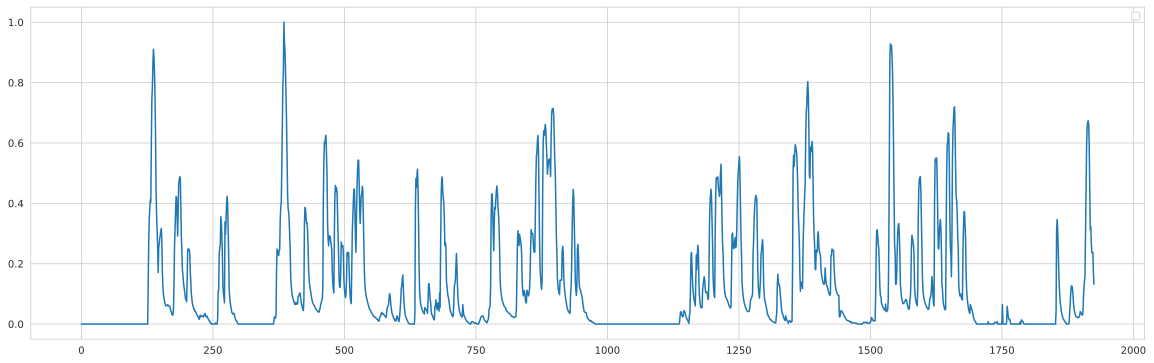

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
plt.plot(out_data)
ax.legend(loc='upper right')
plt.show()

In [ ]:
input_dim = x_train.shape[1]

# Build the model
model = keras.Sequential()

model.add(LSTM(units = 9, return_sequences = True, input_shape=(input_dim, 1), activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units = 9, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1, activation='relu'))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[rmse, nse])
model.summary()

# Fitting the model to the Training set
history = model.fit(x_train, y_train, epochs = 350, batch_size = 100, validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 11, 9)             396       
                                                                 
 dropout_2 (Dropout)         (None, 11, 9)             0         
                                                                 
 lstm_3 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_3 (Dropout)         (None, 9)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 10        
                                                                 
Total params: 1090 (4.26 KB)
Trainable params: 1090 (4.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/350
13/13 [===

In [ ]:
print(get_metrics(history))
plot_history(history, 'Train - Input: Rain Satellite + Pluv + Level from 3 stations - Otput: Level in Durazno station')

NameError: name 'history' is not defined

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
 dense_2 (Dense)             (None, 9)                 90        
                                                                 
 dense_3 (Dense)             (None, 1)                 10        
                                                                 
Total params: 190 (760.00 Byte)
Trainable params: 190 (760.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/350
13/13 [==============================] - 1s 24ms/step - loss: 0.1153 - rmse: 0.1153 - nse: -0.2262 - val_loss: 0.0994 - val_rmse: 0.0994 - val_nse: -0.0271
Epoch 2/350
13/13 [==============================] - 0s 6ms/step - loss: 0.0944 - rmse: 0.0944 - nse: 0.1485 - v

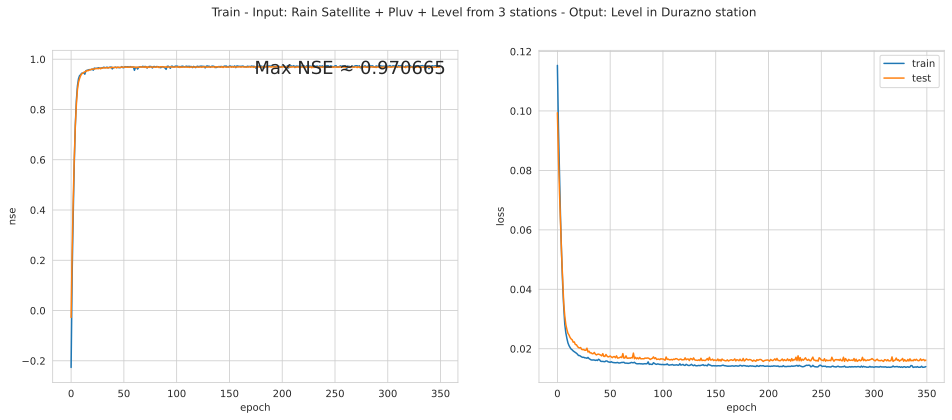

In [ ]:
# Implemnt MLP neural network

input_dim = x_train.shape[1]
model = Sequential()

model.add(Dense(9,input_shape=(input_dim,),activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse, nse])
model.summary()

history = model.fit(x_train, y_train, epochs=350, batch_size=100, validation_data=(x_val, y_val))

print(get_metrics(history))
plot_history(history, 'Train - Input: Rain Satellite + Pluv + Level from 3 stations - Otput: Level in Durazno station')

In [ ]:
# Imprimir caracteristicas del modelo, funciones de activacion
model.layers[0].get_config()



{'name': 'dense_1',
 'trainable': True,
 'dtype': 'float32',
 'batch_input_shape': (None, 9),
 'units': 9,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

16/16 [==============================] - 0s 1ms/step
(481, 9) (481, 9)
481


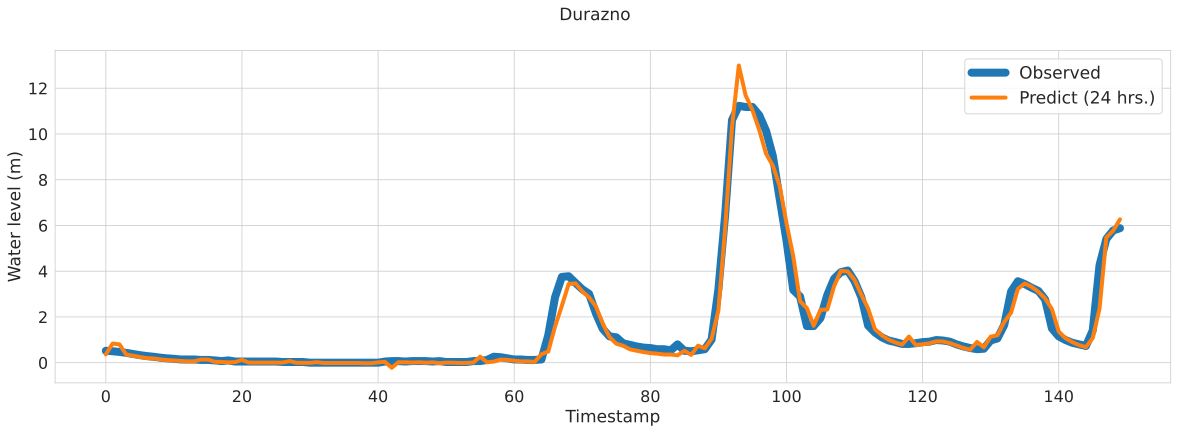

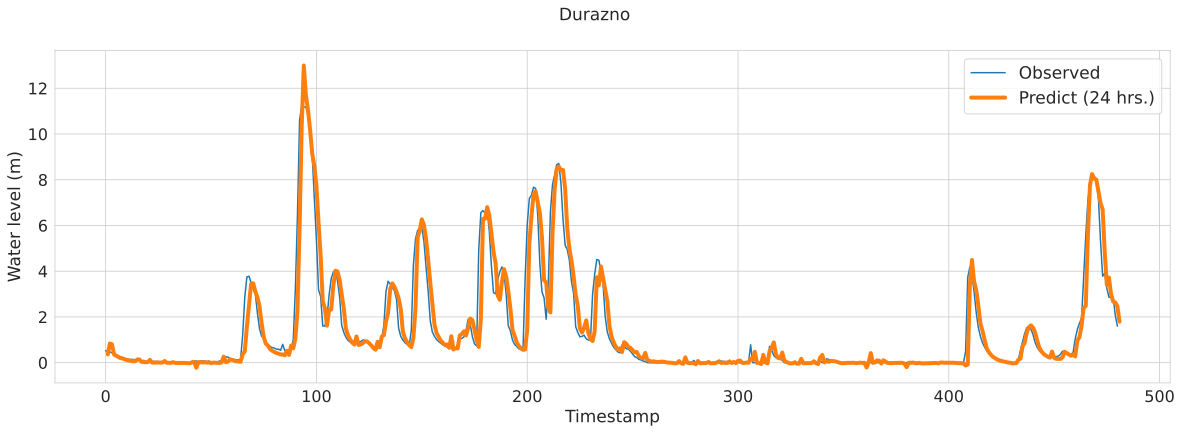

Text(0, 0.5, 'predict values')

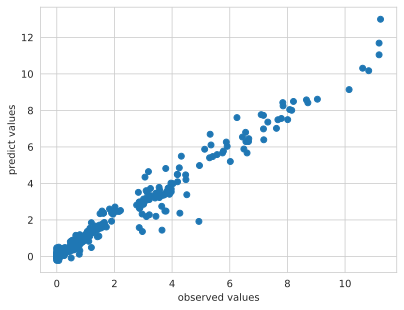

In [ ]:
### Plot results

predict_values = model.predict(x_test)

predict_dataset = np.zeros(shape=(len(predict_values), 9))
predict_dataset[:,] = predict_values
predict_dataset = scaler.inverse_transform(predict_dataset)


test_dataset = np.zeros(shape=(len(y_test), 9))
test_dataset[:,8] = y_test
test_dataset = scaler.inverse_transform(test_dataset)

print(predict_dataset.shape, test_dataset.shape)


n_size = 150
total_size = predict_dataset.shape[0]
print(total_size)

start = 0

fig, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(test_dataset[:,8][start:n_size+start], label='Observed', linewidth=8.0)
plt.plot(predict_dataset[:,8][start:(n_size+start)], label='Predict ('+ str(i*24) + ' hrs.)', linewidth=4.0)
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Durazno', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()


fig2, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(total_size), test_dataset[:,8][:total_size], label='Observed')
plt.plot(range(i,total_size+i), predict_dataset[:,8][:total_size], label='Predict ('+ str(i*24) + ' hrs.)', linewidth=4.0)
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Durazno', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()

#scatter plot
plt.scatter(test_dataset[:,8][:total_size] , predict_dataset[:,8][:total_size])
plt.xlabel('observed values')
plt.ylabel('predict values')

In [ ]:
# Guardar datos predichos y reales en un csv
df_2 = pd.DataFrame(columns = ['Date', 'Predichos', 'Reales'])
df_2['Date']=df['dt'].iloc[1446:1927]
df_2['Predichos']=predict_dataset[:,8]
df_2['Reales']=test_dataset[:,8]

# Graficar Predichos vs Reales en el tiempo
plt.plot(df_2['Date'], df_2['Predichos'], label='Predichos')
plt.plot(df_2['Date'], df_2['Reales'], label='Reales')
plt.legend()
plt.show()

# Guardar como csv
df_2.to_csv('Predichos_Reales_Durazno.csv', sep=',')

In [ ]:
print(len(df))

1927


#Rio Yi basin - Durazno solo nivel

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
# Considera como entrada los datos de precipitación y nivel de todas las estaciones para el tiempo t
x = scaler.fit_transform(data[[
    'Sarandi_del_Yi_precipitation','Sarandi_del_Yi_level',
    'Polanco_precipitation', 'Polanco_level',
    'Durazno_precipitation', 'Durazno_level']].values)

#Considera como salida los datos de nivel para la estacion de salida para el tiempo t + 1
#y = x[:,1::2]
y = x[:,5]

#Separa los conjuntos de datos de entrenamiento y test para una fecha de interes (Esta fecha puede ser modificada a su gusto respetando los porcentajes de datos de entrenamiento y test)
date_split = pd.to_datetime(datetime.datetime(year=2019, month=3, day=15, hour=7, minute=0))

train_index = data.loc[data.index<date_split]

i = 1 #Dia de predicción

## Remover el ultimo tiempo de df de x y el primeiro de df de y
in_data = x[:-i]
out_data = y[i:]

print(in_data.shape)
print(out_data.shape)

#Split train y test data
x_train_without_test = in_data[0:train_index.shape[0],]
y_train_without_test = out_data[0:train_index.shape[0],]

x_test = in_data[train_index.shape[0]:,]
y_test = out_data[train_index.shape[0]:,]

x_train, x_val, y_train, y_val = train_test_split(x_train_without_test, y_train_without_test, test_size=0.2, random_state=seed_number)

(2016, 6)
(2016,)


In [ ]:

# fig, ax = plt.subplots(figsize = (20,6))
# plt.plot(in_data)
# plt.plot(out_data)
# ax.legend(loc='upper right')
# plt.show()

In [ ]:
input_dim = x_train.shape[1]
model = Sequential()

model.add(Dense(6,input_shape=(input_dim,),activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse, nse])
model.summary()

history = model.fit(x_train, y_train, epochs=600, batch_size=100,
                        validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 91 (364.00 Byte)
Trainable params: 91 (364.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/600
13/13 [==============================] - 1s 30ms/step - loss: 0.1304 - rmse: 0.1304 - nse: -0.4969 - val_loss: 0.1132 - val_rmse: 0.1132 - val_nse: -0.1587
Epoch 2/600
13/13 [==============================] - 0s 8ms/step - loss: 0.1139 - rmse: 0.1139 - nse: -0.1105 - va

(0.014723195694386959, 0.9731019735336304)


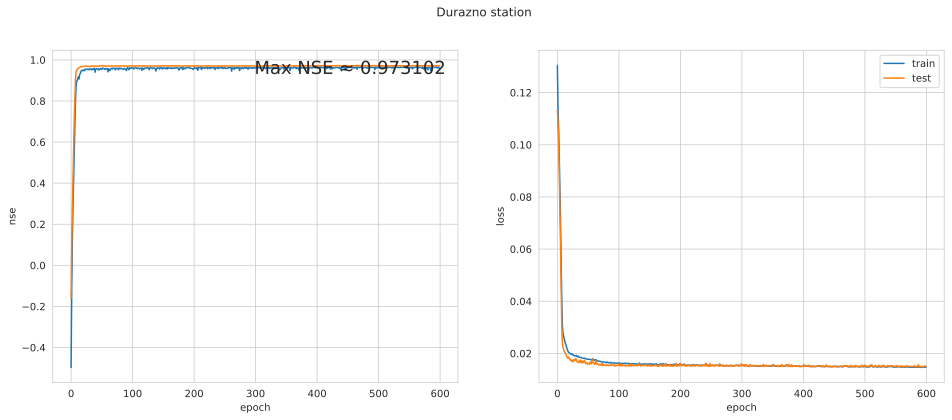

In [ ]:
print(get_metrics(history))
plot_history(history, 'Durazno station')

16/16 [==============================] - 0s 2ms/step
(481, 6) (481, 6)
481


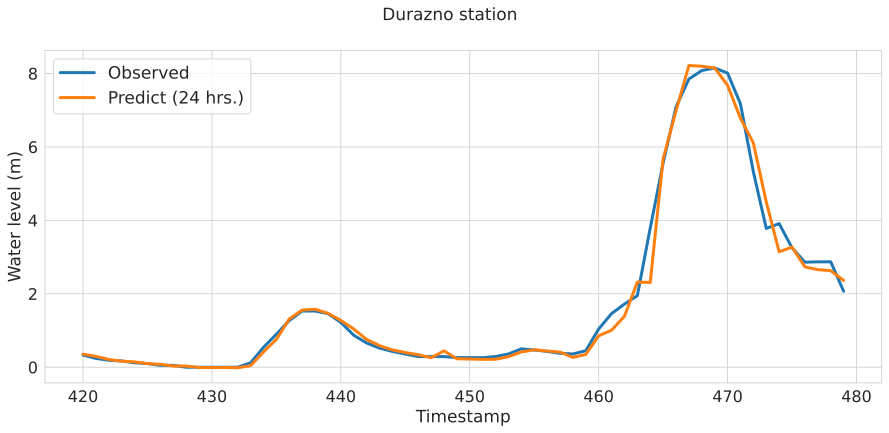

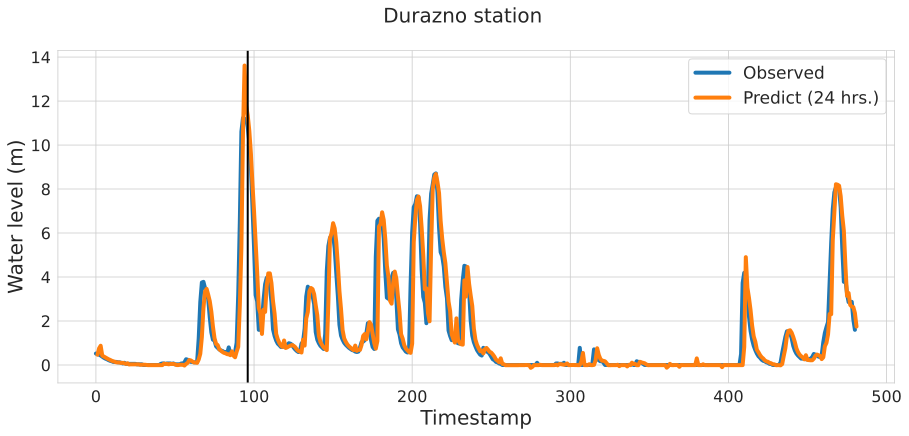

In [ ]:
predict_values = model.predict(x_test)

predict_dataset = np.zeros(shape=(len(predict_values), 6))
predict_dataset[:,] = predict_values
predict_dataset = scaler.inverse_transform(predict_dataset)


test_dataset = np.zeros(shape=(len(y_test), 6))
test_dataset[:,5] = y_test
test_dataset = scaler.inverse_transform(test_dataset)

print(predict_dataset.shape, test_dataset.shape)


n_size = 60
total_size = predict_dataset.shape[0]
print(total_size)

start = 420

fig, (ax1) = plt.subplots(1,1, figsize=(15, 6))
plt.plot(range(start,n_size+start), test_dataset[:,5][start:n_size+start], label='Observed', linewidth=3.0)
plt.plot(range(start,n_size+start), predict_dataset[:,5][start:(n_size+start)], label='Predict ('+ str(i*24) + ' hrs.)', linewidth=3.0)
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Durazno station', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()


fig2, (ax1) = plt.subplots(1,1, figsize=(15, 6))
plt.plot(range(total_size), test_dataset[:,5][:total_size], label='Observed', linewidth=4.0)
plt.plot(range(i,total_size+i), predict_dataset[:,5][:total_size], label='Predict ('+ str(i*24) + ' hrs.)', linewidth=4.0)
#plt.axhline(y=7.052, xmin=0, xmax=1)
#plt.axhline(y=2.024, xmin=0, xmax=1, color='green', linewidth=2.0)
#plt.axhline(y=6.5, xmin=0, xmax=1, color='black', linewidth=2.0)
plt.axvline(x=96, ymin=0, ymax=1, color='black', linewidth=2.0)

#plt.grid()
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Durazno station', fontsize=20)
ax1.set_ylabel('Water level (m)', fontsize=20)
ax1.set_xlabel('Timestamp',fontsize=20)

plt.show()

Text(0, 0.5, 'Predict values')

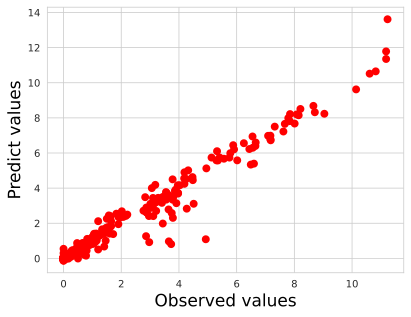

In [ ]:
#Gráfico de dispersión de valores predichos y observados
plt.scatter(test_dataset[:,5][:total_size] , predict_dataset[:,5][:total_size], color='r', linewidth=2.0)
plt.xlabel('Observed values', fontsize=17, color='black')
plt.ylabel('Predict values', fontsize=17, color='black')

## Plots predicciones

In [ ]:
Forecast = pd.DataFrame(columns = ['Date', 'Level-1day', 'Level-7days'])

In [ ]:
Forecast['Date']=df['dt'].iloc[1536:2192]

In [ ]:
Forecast['Precipitation']=df['Durazno_precipitation'].iloc[1536:2192]

In [ ]:
Forecast['Test-1day']=test_dataset[:,5]

In [ ]:
Forecast['Pred-1day']=predict_dataset[:,5]

In [ ]:
Forecast

,Date,Level-1day,Level-7days,Precipitation,Test-1day,Pred-1day
1536,2019-03-17,NaN,NaN,12.0,0.52,0.467212
1537,2019-03-18,NaN,NaN,19.0,0.50,0.756004
1538,2019-03-19,NaN,NaN,0.0,0.47,0.875050
1539,2019-03-20,NaN,NaN,0.0,0.43,0.425804
1540,2019-03-21,NaN,NaN,0.0,0.38,0.384801
...,...,...,...,...,...,...
2012,2020-07-05,NaN,NaN,0.0,2.86,2.731649
2013,2020-07-06,NaN,NaN,0.0,2.87,2.656454
2014,2020-07-07,NaN,NaN,0.0,2.87,2.629663
2015,2020-07-08,NaN,NaN,0.0,2.07,2.361951


In [ ]:
pd.to_datetime(Forecast['Date'])

1536   2019-03-17
1537   2019-03-18
1538   2019-03-19
1539   2019-03-20
1540   2019-03-21
          ...    
2012   2020-07-05
2013   2020-07-06
2014   2020-07-07
2015   2020-07-08
2016   2020-07-09
Name: Date, Length: 481, dtype: datetime64[ns]

In [ ]:
Forecasting=Forecast.set_index('Date')

In [ ]:
Forecasting


,Level-1day,Level-7days,Precipitation,Test-1day,Pred-1day
Date,,,,,
2019-03-17,NaN,NaN,12.0,0.52,0.467212
2019-03-18,NaN,NaN,19.0,0.50,0.756004
2019-03-19,NaN,NaN,0.0,0.47,0.875050
2019-03-20,NaN,NaN,0.0,0.43,0.425804
2019-03-21,NaN,NaN,0.0,0.38,0.384801
...,...,...,...,...,...
2020-07-05,NaN,NaN,0.0,2.86,2.731649
2020-07-06,NaN,NaN,0.0,2.87,2.656454
2020-07-07,NaN,NaN,0.0,2.87,2.629663


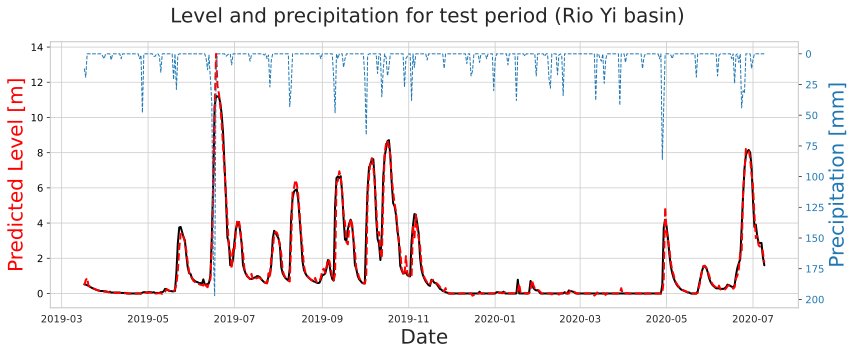

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:k'
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Predicted Level [m]', color='red', fontsize=20)
ax1.plot(Forecast['Date'], Forecast['Test-1day'], label='Observed', color='k', linewidth=2.0)
ax1.plot(Forecast['Date'], Forecast['Pred-1day'], label='Predicted', linestyle='dashed', color='red', linewidth=2.0)
# plt.axhline(y=2.024, xmin=0, xmax=1, color='green', linewidth=2.0)
# plt.axhline(y=6.5, xmin=0, xmax=1, color='black', linewidth=2.0)
ax1.tick_params(axis='y', labelcolor='k')

# ax2 = ax1.twinx()
# color = 'tab:green'
# #ax2.set_xlabel('Date')
# #ax2.set_ylabel('Level [m]', color=color)
# ax2.plot(Forecast['Date'], Forecast['Pred-1day'], color=color)
# #ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel('Precipitation [mm]', color=color, fontsize=20)  # we already handled the x-label with ax1
ax3.plot(Forecast['Date'], Forecast['Precipitation'], linestyle='dashed', color=color, linewidth=1.0)
ax3.invert_yaxis()
ax3.tick_params(axis='y', labelcolor=color)


plt.suptitle('Level and precipitation for test period (Rio Yi basin)', fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('mi_grafico.png')
plt.grid()
#plt.legend(fontsize=17)
plt.show()

# save the figure as a bytes string in the svg format.
# f = io.BytesIO()
# plt.savefig(f, format="svg")

In [ ]:
Forecasting.columns

Index(['Level-1day', 'Level-7days', 'Precipitation', 'Test-1day', 'Pred-1day'], dtype='object')

In [ ]:
Forecasting=Forecasting.drop(columns=['Level-1day', 'Level-7days', 'Precipitation'])

Text(0.5, 0, 'Date')

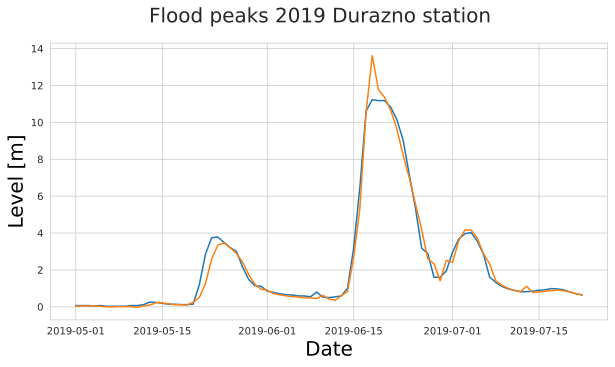

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Flood peaks 2019 Durazno station', fontsize=20)
plt.plot(Forecasting.loc['2019-05-1' : '2019-07-22' ])
ax.set_ylabel('Level [m]', color='k', fontsize=20)
ax.set_xlabel('Date', color='k', fontsize=20)

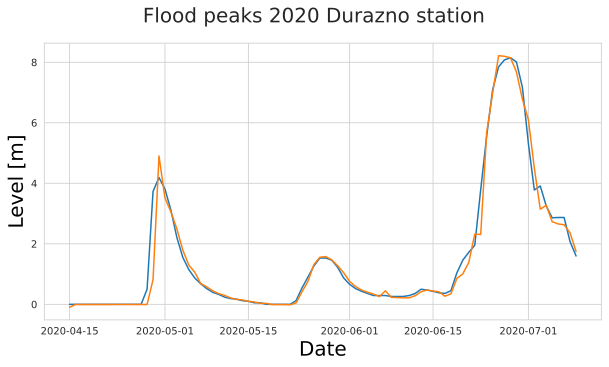

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Flood peaks 2020 Durazno station', fontsize=20)
plt.plot(Forecasting.loc['2020-04-15' : '2020-07-22' ])
ax.set_ylabel('Level [m]', color='k', fontsize=20)
ax.set_xlabel('Date', color='k', fontsize=20)
plt.show()

In [ ]:
Forecasting.to_csv('flood_Durazno.csv', sep=',')